<a href="https://colab.research.google.com/github/askmuhsin/Session_5_assignment/blob/main/experiment_4/Experiment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target:
* Increase LR to .02
* Remove Dropout
* Background
  * Last model was trained on a dataset with more augmentation, and therefore was taking more epochs to converge.
  * Now Trying with a higher learning rate, in order to get desired accuracy within 15 epochs.
 
# Results:
* Parameters: 9,958
* Best Training Accuracy: 98.53% (EPOCH 15)
* Best Test Accuracy: 99.42% (EPOCH 10)
 
# Analysis:
* By removing Dropout and increasing learning rate to 0.20 the test accuracy has reached 99.42% stably.


# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import torchvision

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [36]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomAffine(
                                      #     degrees=0,
                                      #     scale=(0.8, 0.9),
                                      #     shear=3
                                      #  ),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [37]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [38]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


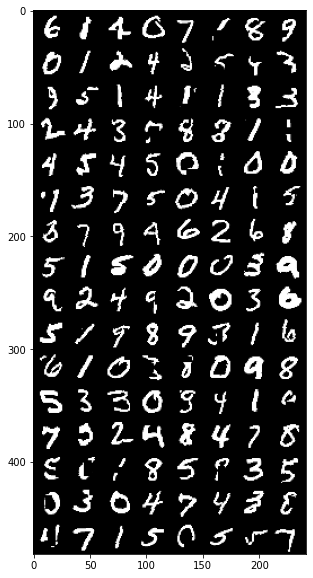

In [39]:
for data, target in train_loader:
  break
grid_img = torchvision.utils.make_grid(data.cpu().detach())
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

# The model
Let's start with the model we first saw

In [57]:
import torch.nn.functional as F
dropout_value = 0.0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=7, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

         # CONVOLUTION BLOCK 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
         # CONVOLUTION BLOCK 6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
         # CONVOLUTION BLOCK 7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        # self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.convblock3(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [58]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
           Dropout-4            [-1, 6, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [59]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [60]:
# from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.020, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.1349336951971054 Batch_id=468 Accuracy=89.00: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9825/10000 (98.25%)

EPOCH: 1


Loss=0.19439269602298737 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9890/10000 (98.90%)

EPOCH: 2


Loss=0.05929729714989662 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9894/10000 (98.94%)

EPOCH: 3


Loss=0.12592129409313202 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9916/10000 (99.16%)

EPOCH: 4


Loss=0.03783724084496498 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.023684559389948845 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.032622817903757095 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.026057422161102295 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.05491936579346657 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.043765727430582047 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 10


Loss=0.04573361948132515 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.047233179211616516 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.06386258453130722 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.0688052847981453 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.034591007977724075 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.011242914944887161 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.08259566128253937 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

EPOCH: 17


Loss=0.024090871214866638 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.1136251911520958 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.010002445429563522 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]



Test set: Average loss: 0.0160, Accuracy: 9949/10000 (99.49%)



# Let's Train and test our model

Text(0.5, 1.0, 'Test Accuracy')

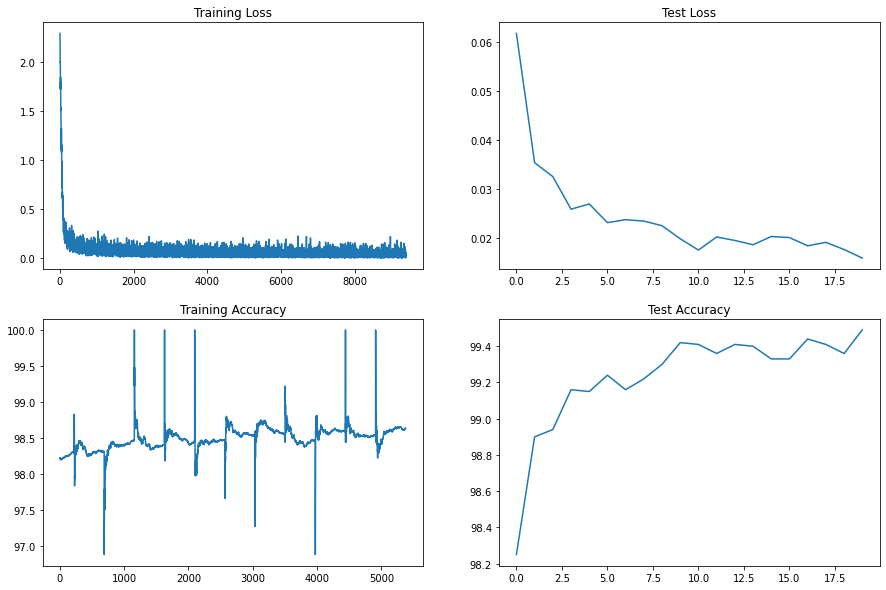

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [62]:
import pandas as pd

In [63]:
df = pd.DataFrame()
df['batch_avg_train_acc'] = pd.DataFrame(train_acc).rolling(469).mean().dropna()[::469].reset_index(drop=True)[0]
df['train_acc'] = pd.DataFrame(train_acc)[468::469].reset_index(drop=True)[0]
df['test_acc'] = pd.DataFrame(test_acc)
df['train_losses'] = pd.DataFrame([x.item() for x in train_losses])[468::469].reset_index(drop=True)[0]
df['test_losses'] = pd.DataFrame(test_losses)
df[['test_acc', 'train_acc', 'batch_avg_train_acc', 'train_losses', 'test_losses']]

,test_acc,train_acc,batch_avg_train_acc,train_losses,test_losses
0,98.25,89.003333,74.865359,0.134934,0.061771
1,98.90,96.860000,96.789122,0.194393,0.035420
2,98.94,97.286667,97.097241,0.059297,0.032587
3,99.16,97.633333,97.636844,0.125921,0.025944
4,99.15,97.883333,97.797699,0.037837,0.027013
5,99.24,98.065000,98.049560,0.023685,0.023204
6,99.16,98.115000,98.188930,0.032623,0.023801
7,99.22,98.163333,98.133595,0.026057,0.023516
8,99.30,98.295000,98.223855,0.054919,0.022574
9,99.42,98.298333,98.322067,0.043766,0.019911


In [75]:
df[:15].max()

batch_avg_train_acc    98.572370
train_acc              98.531667
test_acc               99.420000
train_losses            0.194393
test_losses             0.061771
dtype: float64

In [66]:
max_test_epoch = 9
df[['test_acc', 'train_acc']][max_test_epoch - 3:max_test_epoch + 6]

,test_acc,train_acc
6,99.16,98.115000
7,99.22,98.163333
8,99.30,98.295000
9,99.42,98.298333
10,99.41,98.465000
11,99.36,98.401667
12,99.41,98.451667
13,99.40,98.476667
14,99.33,98.531667


In [67]:
df.min()

batch_avg_train_acc    74.865359
train_acc              89.003333
test_acc               98.250000
train_losses            0.010002
test_losses             0.015982
dtype: float64

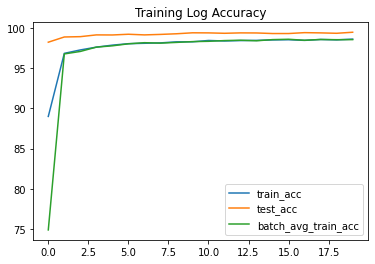

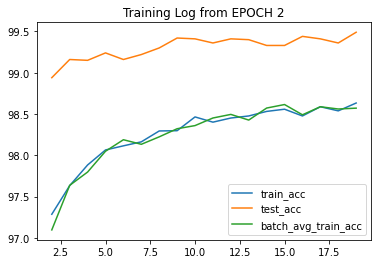

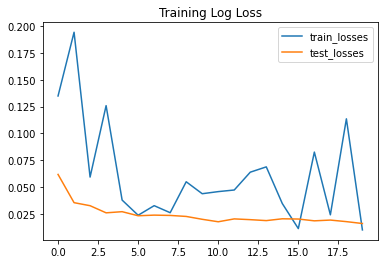

In [68]:
df[['train_acc', 'test_acc', 'batch_avg_train_acc']].plot(title="Training Log Accuracy")
df[['train_acc', 'test_acc', 'batch_avg_train_acc']][2:].plot(title="Training Log from EPOCH 2")
df[['train_losses', 'test_losses']].plot(title="Training Log Loss")

In [69]:
df[15:].var()

batch_avg_train_acc    0.002152
train_acc              0.003398
test_acc               0.004030
train_losses           0.002217
test_losses            0.000002
dtype: float64

In [70]:
## inspect data
model.eval()
test_loss = 0
correct = 0

wrong_correct = []
wrong_predicted = []
wrong_image_data = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        status = pred.eq(target.view_as(pred))
        # correct += status.sum().item()

        mistakes, _ = torch.where(status==False)
        if len(mistakes):
          m_data = data[mistakes]
          m_target = target[mistakes]
          m_output = output[mistakes]
          m_pred = pred[mistakes]
          correct = [x.item() for x in m_target.cpu().detach()]
          predicted = [x.item() for x in m_pred.cpu().detach()]
          image_data = [x for x in m_data.cpu().detach()]

          wrong_correct.extend(correct)
          wrong_predicted.extend(predicted)
          wrong_image_data.extend(image_data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [71]:
from collections import Counter

In [72]:
len(wrong_correct), len(wrong_predicted), len(wrong_image_data)

(51, 51, 51)

In [73]:
mskts = pd.DataFrame(Counter(wrong_correct).most_common(), columns=['number', 'number of times prediction error'])
mskts

,number,number of times prediction error
0,9,8
1,5,8
2,6,7
3,7,6
4,4,6
5,8,5
6,2,4
7,3,3
8,0,3
9,1,1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 9 || Mistakenly predicted as [8, 4, 4, 5, 5, 4, 4, 4]


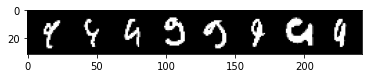

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 5 || Mistakenly predicted as [6, 3, 3, 6, 7, 3, 3, 6]


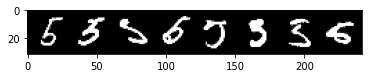

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 6 || Mistakenly predicted as [8, 1, 0, 0, 4, 0, 1]


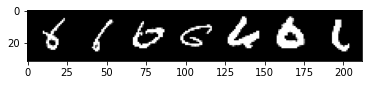

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 7 || Mistakenly predicted as [9, 1, 3, 2, 1, 2]


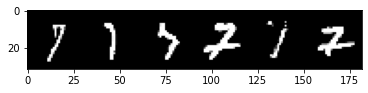

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 4 || Mistakenly predicted as [9, 8, 9, 9, 9, 9]


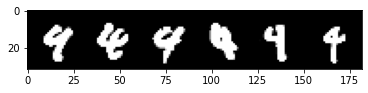

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 8 || Mistakenly predicted as [9, 0, 9, 5, 3]


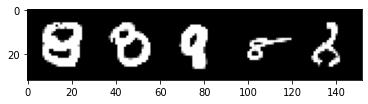

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 2 || Mistakenly predicted as [7, 0, 7, 4]


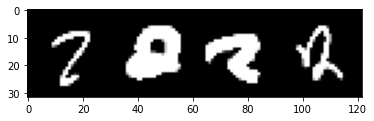

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 3 || Mistakenly predicted as [8, 5, 5]


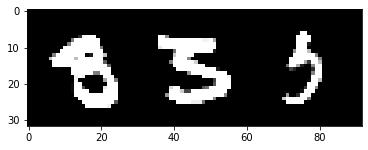

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 0 || Mistakenly predicted as [6, 7, 6]


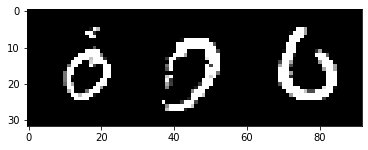

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 1 || Mistakenly predicted as [2]


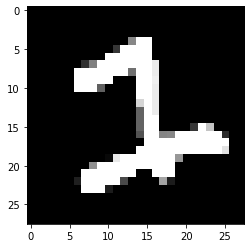

In [74]:
for select_num in mskts['number']:
  # select_num = 9
  img_data_temp = []
  wps = []
  for wc, wp, wi in zip(wrong_correct, wrong_predicted, wrong_image_data):
    if wc == select_num:
      wps.append(wp)
      img_data_temp.append(wi)

  wrong_images_temp = torch.stack(img_data_temp)
  print()
  print(f"Correct Label -- {select_num} || Mistakenly predicted as {wps}")

  grid_img = torchvision.utils.make_grid(wrong_images_temp)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()